In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import wandb
import utils
from torch.utils.data import DataLoader
import tqdm as tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from utils import load_csv, drop_cols, remove_strings, groupedAvg, subsample, normalize_df
from create_dataset import AnimalDataset, AnimalDatasetEmbedding, UnpairedDataset
from generators import BasicGenerator, SkipConGenerator, OneHotGenerator
from discriminators import MultiChannelDiscriminator 

/home/johann/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
# config
ALLDATA = True
UNPAIRED = True 
SKIPCONNECTIONS = False
EMBEDDING = False
ONEHOTENCODING = False

MultiStepLR = True
ReduceLROnPlateau = False

if MultiStepLR  == True and ReduceLROnPlateau == True:
    #raise error
    print("Error: Only one learning rate scheduler can be used at a time.")
    raise (NameError)
if MultiStepLR == False and ReduceLROnPlateau == False:
    print("Error: At least one learning rate scheduler must be used.")
    raise (NameError)



# DISCRIMINATOR = MultiChannelDiscriminator
# GENERATOR = BasicGenerator   # BasicGenerator, SkipConGenerator

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 1
LEARNING_RATE = 1e-2 
NUM_WORKERS = 16
NUM_EPOCHS = 20

SIG_A = "AoP"           # Drucksignal Hauptschlagader = Aortendruck
SIG_B = "VADcurrent"    # VAD Strom [A] – Pumpemstrom in Ampere
SIG_C = "VadQ"          # Fluss durch VAD (VAD = Ventrikular assistance device = Pumpe) = Pumpenfluss
SIG_D = "LVP"           # Ventrikeldruck links = Drucksignal der linken Herzkammer
TARGET = "LVtot_kalibriert"  # RVtot_kalibriert existiert auch
source_signals = [SIG_D]
CHANNELS = len(source_signals)
WINDOW = 256

GENERATION_AFTER_EPOCH = NUM_EPOCHS # number of epochs after which the model generates a sample

# Use adversarial loss
GAN_LOSS = True   # adversarial loss
LAMBDA_GAN = 1.0
# Use cycle consistency loss
CYCLE = True
LAMBDA_CYCLE = 1.0
# Use supervised loss
SUPERVISED = False 
LAMBDA_SUPERVISED = 1.0
# Use Identity loss
IDENTITY = False
LAMBDA_IDENTITY = 10.0

normnalisieren pro datei
mit einem signal und nur phase 1 duchlaufen lassen
daten anschauen und range vergleichen

In [3]:
# iterate over files in path and load them into a dataframe
# import necessary libraries
import os
import glob
  
# use glob to get all the csv files 
# in the folder
path = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files" 
csv_files = glob.glob(os.path.join(path, "*.csv"))
  
df = pd.DataFrame()
scaler = StandardScaler() 
# loop over the list of csv files
for f in csv_files:
      
    # read the csv file
    df_temp = pd.read_csv(f, sep=";")
    df_temp = utils.drop_cols(df_temp)
    df_temp = df_temp.dropna()
    df_temp = utils.remove_strings(df_temp)
    df_temp = utils.subsample(df_temp, 10)
    df_temp = utils.normalize_df(df_temp, scaler)  
      
    # print the content
    df = pd.concat([df, df_temp], axis=0)
    

print(df.shape)

(6022044, 13)


/home/johann/Desktop/GitHub repos/Master_thesis/utils.py:135: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  axs[0].plot(df[variables[0]][:length])
/home/johann/Desktop/GitHub repos/Master_thesis/utils.py:137: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  axs[1].plot(df[variables[1]][:length])
/home/johann/Desktop/GitHub repos/Master_thesis/utils.py:139: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treate

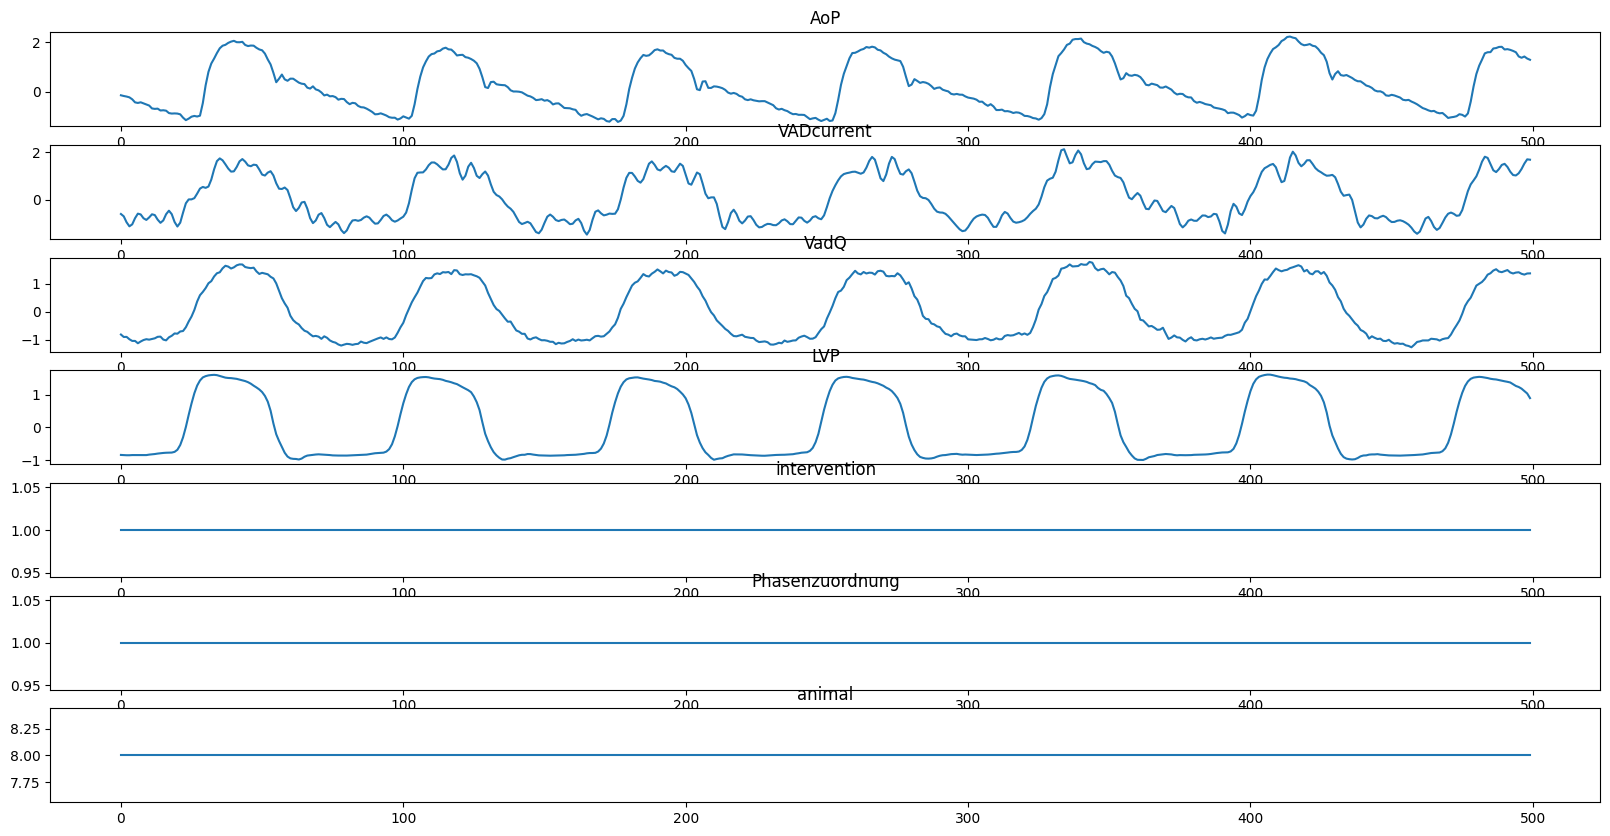

In [4]:
utils.visualize(df, [SIG_A, SIG_B, SIG_C, SIG_D, 'intervention', 'Phasenzuordnung', 'animal'], 500)

#### Load data and preprocess
We load the whole data, drop unnecessary columns, remove strings and NaN values and then we downsample by a factor of 10.

In [5]:
# def load_and_preprocess(path):
#     df = utils.load_csv(path)
#     df = utils.drop_cols(df)
#     df = df.dropna()
#     df = utils.remove_strings(df)
#     df = utils.subsample(df, 10)
#     return df

In [6]:
# if ALLDATA == True:
#     # Load all the data and drop unnecessary columns
#     # We load the data separately, to avoid a Runtime error

#     # all the data
#     path_1 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_1"  
#     path_2 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_2"
#     path_3 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_3"
#     path_4 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_4"

#     df_1 = load_and_preprocess(path_1)
#     df_2 = load_and_preprocess(path_2)
#     df_3 = load_and_preprocess(path_3)
#     df_4 = load_and_preprocess(path_4)

#     # concatenate the separate dataframes
#     df = pd.concat([df_1, df_2, df_3, df_4], axis=0, ignore_index=True)
#     df = df.dropna()

#     print('Size of the dataset after subsampling',df.shape)
#     print('Size of Phase 1: ', df.loc[df['Phasenzuordnung'] == 1].shape)
#     print('Size of Phase 2: ', df.loc[df['Phasenzuordnung'] == 2].shape)
#     print('Size of Phase 3: ', df.loc[df['Phasenzuordnung'] == 3].shape)
#     print('Size of Phase 4: ', df.loc[df['Phasenzuordnung'] == 4].shape)
#     print('SIze of Phase 5: ', df.loc[df['Phasenzuordnung'] == 5].shape)
   


In [7]:
 # select Phasenzuordnung = 1 
df = df.loc[df['Phasenzuordnung'].isin([1])]
print('Size of the dataset after selecting Phasenzuordnung 1',df.shape)

Size of the dataset after selecting Phasenzuordnung 1 (751120, 13)


In [8]:
print('Size of the dataset with data from phase 1',df.shape)
print('Size of Phase 1: ', df.loc[df['Phasenzuordnung'] == 1].shape)
print('Size of Phase 2: ', df.loc[df['Phasenzuordnung'] == 2].shape)
print('Size of Phase 3: ', df.loc[df['Phasenzuordnung'] == 3].shape)
print('Size of Phase 4: ', df.loc[df['Phasenzuordnung'] == 4].shape)
print('SIze of Phase 5: ', df.loc[df['Phasenzuordnung'] == 5].shape)

Size of the dataset with data from phase 1 (751120, 13)
Size of Phase 1:  (751120, 13)
Size of Phase 2:  (0, 13)
Size of Phase 3:  (0, 13)
Size of Phase 4:  (0, 13)
SIze of Phase 5:  (0, 13)


#### Experiment

Wir nutzen alle Daten. Wir vergleichen 2 Generator: Einer hat Skip connections und der andere nicht

#### Normalize
Normalize the data per animal. We use the data from the first phase to normalize each animal, because no intervention occured in the first phase

In [9]:
phase_1 = df.loc[df['Phasenzuordnung'] == 1]
phase_1 = phase_1.groupby('animal').filter(lambda x: len(x) > 10)
#phase_1 = utils.normalize_df(phase_1, scaler)

# check in which range the values are
print('TARGET: ', phase_1[TARGET].min(), phase_1[TARGET].max())
print('SIG_A: ', phase_1[SIG_A].min(), phase_1[SIG_A].max())
print('SIG_B: ', phase_1[SIG_B].min(), phase_1[SIG_B].max())
print('SIG_C: ', phase_1[SIG_C].min(), phase_1[SIG_C].max())
print('SIG_D: ', phase_1[SIG_D].min(), phase_1[SIG_D].max())

TARGET:  -2.8304405318188035 2.71766176040528
SIG_A:  -4.843552994039782 8.027734338011367
SIG_B:  -9.347553268132133 11.306370479400863
SIG_C:  -5.1045761492348 5.793431768787424
SIG_D:  -1.3689366506220833 3.4045567040516103


Phase 1:  -6.99799273920608 4.335289069042426
Phase 1:  -3.5434597763744633 5.252366277995206
Phase 1:  -8.665034664438295 7.4700718657707155
Phase 1:  -4.371249702433351 3.5517465586221273
Phase 1:  -1.426121394877716 2.9457623392662238


"AoP"             : -4.84 - 8.03 (pro Datei mit Phase 1 normalisiert) ,     -3.54 - 5.25   (pro Tier mit Phase 1 normaalisiert)
"VADcurrent"      : -9.35 - 11.31 (pro Datei mit Phase 1normalisiert) ,     -8.67 - 7.47   (pro Tier mit Phase 1 normaalisiert)
"VadQ"            : -5.10 - 5.79 (pro Datei mit Phase 1normalisiert)  ,     -4.37 - 3.55   (pro Tier mit Phase 1 normaalisiert)
"LVP"             : -1.37 - 3.40 (pro Datei mit Phase 1normalisiert)  ,     -1.43 - 2.95   (pro Tier mit Phase 1 normaalisiert)
"LVtot_kalibriert": -2.83 - 2.72 (pro Datei mit Phase 1normalisiert)  ,     -6.99 - 4.34   (pro Tier mit Phase 1 normaalisiert)

In [10]:
# print(len(df['animal'].unique()))
# df = df.groupby('animal').filter(lambda x: len(x) > 10)
# #df = utils.normalize_df(df)
# # visualize the data after normalization
# utils.visualize(df, [SIG_A, SIG_B, SIG_C, SIG_D, 'intervention', 'Phasenzuordnung', 'animal'], 500)

#### Split data into train and test split

In [11]:
# group by animal size in percent
# df_grouped = df.groupby('animal').size().reset_index(name='counts')
# df_grouped['counts'] = df_grouped['counts'] / df_grouped['counts'].sum() * 100
# df_grouped

#### Drop animal data
We drop animals from the dataframe, if they have less than 10 data points. Initially, we have 56 animals and after dropping those with close to no data points, we are left with 25 animals

In [12]:
print(len(df['animal'].unique()))
# remove animals with less than 10 data points
df = df.groupby('animal').filter(lambda x: len(x) > 10)
print('Number of animals after removing those with less than 10 data points: ', len(df['animal'].unique()))

# get all differnent animals
# animals = df['animal'].unique()
# print(animals)

25
Number of animals after removing those with less than 10 data points:  25


#### Test data

The 5 test animals represent 20.20924% of the data

In [13]:
# select animals 2,3, 7, 10 and 16 as test animals
test_animals = [3,4,8,11,17] # 3,4,8,11,17
print('\nTest animal(s):', test_animals)

all_animals = df['animal'].unique()
# remove test animals from train animals
train_animals =  [x for x in all_animals if x not in test_animals]

# test data
df_test = df[df['animal'].isin(test_animals)]

# change the length of the test data to a multiple of the Window size
df_test = df_test.iloc[:len(df_test) - (len(df_test) % WINDOW)]

# train dataframe with only animals from train_animals
df_train = df[df['animal'].isin(train_animals)]
print('\nDifferent animal IDs after removing those that are in the test dataset: ',len(df_train['animal'].unique()))


print('\nTrain data shape:', df_train.shape)
print('\nTest data shape:', df_test.shape)

# lengt of df_train
print('\nThe test dataset is {} percent of the whole data: '.format((len(df_test)/(len(df_train) + len(df_test))) * 100))


Test animal(s): [3, 4, 8, 11, 17]

Different animal IDs after removing those that are in the test dataset:  20

Train data shape: (591930, 13)

Test data shape: (158976, 13)

The test dataset is 21.171225160006713 percent of the whole data: 


In [14]:
# # slelect df_test animal 3
# df_test_3 = df[df['animal'] == 3]
# df_test_4 = df[df['animal'] == 4]
# df_test_8 = df[df['animal'] == 8]
# df_test_11 = df[df['animal'] == 11]
# df_test_17 = df[df['animal'] == 17]
# # change the length of the test data to a multiple of the Window size
# df_test_3 = df_test_3.iloc[:len(df_test_3) - (len(df_test_3) % WINDOW)]
# df_test_4 = df_test_4.iloc[:len(df_test_4) - (len(df_test_4) % WINDOW)]
# df_test_8 = df_test_8.iloc[:len(df_test_8) - (len(df_test_8) % WINDOW)]
# df_test_11 = df_test_11.iloc[:len(df_test_11) - (len(df_test_11) % WINDOW)]
# df_test_17 = df_test_17.iloc[:len(df_test_17) - (len(df_test_17) % WINDOW)]

# print('\nTest data shape animal 3:', df_test_3.shape)
# print('\nTest data shape animal 4:', df_test_4.shape)
# print('\nTest data shape animal 8:', df_test_8.shape)
# print('\nTest data shape animal 11:', df_test_11.shape)
# print('\nTest data shape animal 17:', df_test_17.shape)

# df_test = pd.concat([df_test_3, df_test_4, df_test_8, df_test_11, df_test_17], axis=0, ignore_index=True)
# print('\nTest data shape:', df_test.shape)

# print('\nTrain data shape:', df_train.shape)
# print('\nTest data shape:', df_test.shape)

# # lengt of df_train
# print('\nThe test dataset is {} percent of the whole data: '.format((len(df_test)/(len(df_train) + len(df_test))) * 100))


In [15]:
# df_train should be devidible by 256
# df_train = df_train.iloc[:-(len(df_train) % WINDOW)]
# df_test = df_test.iloc[:-(len(df_test) % WINDOW)]
# df_test.shape

#### Initialize Generator and Discriminator

We also initialize the 2 optimizers, the 2 Learning rate schedulers, the losses


In [24]:
# Generator
if not SKIPCONNECTIONS:
    gen_target = BasicGenerator(INPUTCHANNELS = CHANNELS, OUTPUTCHANNELS = 1).to(DEVICE)
    gen_source = BasicGenerator(INPUTCHANNELS = 1, OUTPUTCHANNELS = CHANNELS).to(DEVICE)

if SKIPCONNECTIONS:
    gen_target = SkipConGenerator(INPUTCHANNELS = CHANNELS, OUTPUTCHANNELS = 1).to(DEVICE)
    gen_source = SkipConGenerator(INPUTCHANNELS = 1, OUTPUTCHANNELS = CHANNELS).to(DEVICE)

# gen_target receives source signals and generates a target signal
# gen_source receives a target signal and generates source signals

# Discriminator
disc_target = MultiChannelDiscriminator(CHANNELS = 1).to(DEVICE)
disc_source = MultiChannelDiscriminator(CHANNELS = CHANNELS).to(DEVICE)

# Optimizers
opt_disc = torch.optim.AdamW(                                         
    list(disc_source.parameters()) + list(disc_target.parameters()), 
    lr=LEARNING_RATE, 
)
opt_gen = torch.optim.AdamW(
    list(gen_source.parameters()) + list(gen_target.parameters()),
    lr=LEARNING_RATE,
)

# Schedulers
if ReduceLROnPlateau:
    gen_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = opt_gen,
                                                            factor=0.1, patience=3, threshold=1e-4,
                                                            min_lr=1e-6,
                                                        )
    disc_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = opt_disc,
                                                                factor=0.1, patience=3, threshold=1e-4,
                                                                min_lr=1e-6,
                                                        )
if MultiStepLR:
    gen_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer = opt_gen, milestones=[5,6,7,8,9], gamma=0.1)
                                                        
    disc_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer = opt_disc, milestones=[5,6,7,8,9], gamma=0.1)

# losses
l1 = nn.L1Loss() 
mse = nn.MSELoss()

#### Create the dataset and DataLoader

In [25]:
if UNPAIRED:
    # create datasets without the embedding information
    train_dataset = UnpairedDataset(df_train, source_signals, target_name = TARGET, test = False, window_length = WINDOW)
    test_dataset = UnpairedDataset(df_test, source_signals, target_name = TARGET, test = True, window_length = WINDOW)
    

if not UNPAIRED:
    # create datasets without the embedding information
    train_dataset = AnimalDataset(df_train, source_signals, target_name = TARGET, test = False, window_length = WINDOW)
    test_dataset = AnimalDataset(df_test, source_signals, target_name = TARGET, test = True, window_length = WINDOW)

# DataLoader
loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True,)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,)


#### Initialize weights and bias

In [26]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Cycle_GAN",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": LEARNING_RATE,
    "epochs": NUM_EPOCHS,
    }
)

Learning rate,█████▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test/Adversarial or GAN loss A,█▁▁▁██████▇█████████
Test/Adversarial or GAN loss B,▃▁▁▁████████████████
Test/Cycle consistency loss A,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test/Cycle consistency loss B,█▂▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test/Discriminator A loss,▃███▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test/Discriminator B loss,▁███████████████████
Test/Discriminator loss,▁███▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
Test/Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Test/Generator loss,▅▁▁▁████████████████
Test/L1 loss between real signal A and fake signals A,▆█▃▄▁▂▃▅▅▆▅▃▅▅▅▃▂▆▅▆


In [27]:
def discriminator_loss(disc, reals, fakes):
    # calculate how close reals are to being classified as real
    real_loss = mse(disc(reals), torch.ones_like(disc(reals)))
    # calculate how close fakes are to being classified as fake
    fake_loss = mse(disc(fakes), torch.zeros_like(disc(fakes)))
    # return the average of real and fake loss
    return (real_loss + fake_loss) / 2


# @torch.cuda.amp.autocast()
def get_disc_loss_no_embedding(sig_A, sig_B,  
                    disc_A, disc_B, gen_A, gen_B, fake_A, fake_B
                    ):
    """
    Return the loss of the discriminator given inputs.
    """
    # generate fakes
    # with torch.no_grad():
    #     fake_B = gen_B(sig_A, phase, intervention).detach()
    #     fake_A = gen_A(sig_B, phase, intervention).detach()
    
    # discriminator loss
    disc_B_loss = discriminator_loss(disc_B, sig_B, fake_B)
    disc_A_loss = discriminator_loss(disc_A, sig_A, fake_A)
    disc_loss = (disc_A_loss + disc_B_loss) / 2

    return disc_loss, disc_A_loss, disc_B_loss

# @torch.cuda.amp.autocast()
def calc_gen_loss_no_embedding(source, target, 
                  gen_source, gen_target, disc_source, disc_target, fake_target, fake_source
                  ):
    loss = 0

    if GAN_LOSS:
        g_source_loss = mse(disc_source(fake_source), torch.ones_like(disc_source(fake_source))) 
        g_target_loss = mse(disc_target(fake_target), torch.ones_like(disc_target(fake_target))) 

        loss += g_source_loss * LAMBDA_GAN + g_target_loss * LAMBDA_GAN
    else:
        g_source_loss = torch.tensor(0)
        g_target_loss = torch.tensor(0)

    if CYCLE:
        rec_target = gen_target(fake_source)
        rec_source = gen_source(fake_target)
        cycle_target_loss = l1(target, rec_target)  # l1 loss in cycle GAN paper
        cycle_source_loss = l1(source, rec_source)  

        loss += cycle_target_loss * LAMBDA_CYCLE + cycle_source_loss * LAMBDA_CYCLE
    else:
        cycle_target_loss = torch.tensor(0)
        cycle_source_loss = torch.tensor(0)

    if SUPERVISED:
        sup_source_loss = mse(source, fake_source)
        sup_target_loss = mse(target, fake_target)

        loss += sup_source_loss * LAMBDA_SUPERVISED + sup_target_loss * LAMBDA_SUPERVISED
    else:
        sup_source_loss = torch.tensor(0)
        sup_target_loss = torch.tensor(0)

    if IDENTITY:
        id_target_loss = l1(target, gen_target(target))
        id_source_loss = l1(source, gen_source(source))

        loss += id_target_loss * LAMBDA_IDENTITY + id_source_loss * LAMBDA_IDENTITY
    else:
        id_target_loss = torch.tensor(0)
        id_source_loss = torch.tensor(0)

    return loss, g_source_loss, g_target_loss, cycle_target_loss, cycle_source_loss, id_target_loss, id_source_loss, sup_source_loss, sup_target_loss

In [28]:
losses = {
    'L1 loss source' : [],
    'L1 loss target' : [],
}

In [29]:
# training loop
from tqdm.auto import tqdm

for epoch in tqdm(range(NUM_EPOCHS)):

    for source, target in loader:
        # convert to float16
        source = source.float() # neccessary to prevent error: "Input type (torch.cuda.DoubleTensor) 
        target = target.float() # and weight type (torch.cuda.HalfTensor) should be the same"
    
        # move to GPU
        source = source.to(DEVICE)
        target = target.to(DEVICE)

        #  ------------------------------- #
        #  ----- train discriminators ---- #
        #  ------------------------------- #
        with torch.no_grad():
            fake_target = gen_target(source).detach()
            fake_source = gen_source(target).detach()

        d_loss, disc_source_loss, disc_target_loss = get_disc_loss_no_embedding(source, target,
                                                            disc_source, disc_target, gen_source, gen_target, 
                                                            fake_source, fake_target
                                                        )

        # update gradients of discriminator 
        opt_disc.zero_grad() 
        d_loss.backward()
        opt_disc.step()
        # d_scaler.scale(d_loss).backward()  
               

        # -------------------------------- #
        # ------- train generators ------- #
        # -------------------------------- # 

        out = calc_gen_loss_no_embedding(source, target,
                                gen_source, gen_target, disc_source, disc_target, 
                                fake_target, fake_source
                                )
        g_loss, g_source_loss, g_target_loss, cycle_target_loss, cycle_source_loss, id_target_loss, id_source_loss, sup_source_loss, sup_target_loss = out

        # update gradients of generator
        opt_gen.zero_grad()
        g_loss.backward()
        opt_gen.step()
        # g_scaler.scale(g_loss).backward()

    # Optimizer step
    # d_scaler.step(opt_disc)  
    # d_scaler.update()

    # g_scaler.step(opt_gen) 
    # g_scaler.update()

    wandb.log({'Train/Discriminator A loss': disc_source_loss.item(),
                'Train/Discriminator B loss': disc_target_loss.item(),
                'Train/Total Discriminator loss': d_loss.item(),
                'Train/Total Generator loss': g_loss.item(),
                'Train/Adversarial loss A': g_source_loss.item(),
                'Train/Adversarial loss B': g_target_loss.item(),
                'Train/Cycle consistency loss A': cycle_source_loss.item(),
                'Train/Cycle consistency loss B': cycle_target_loss.item(),
                'Train/Supervised loss A': sup_source_loss.item(),
                'Train/Supervised loss B': sup_target_loss.item(),
                'Learning rate': opt_gen.param_groups[0]["lr"],
                # 'Train/Identity loss A': id_A_loss.item(),
                # 'Train/Identity loss B': id_B_loss.item()
                })
        

    # ------------------------ #
    # ------ Validation ------ #
    # ------------------------ #

    if (epoch+1) % 1 == 0:

        with torch.no_grad():
            # set models to evaluation mode
            disc_source.eval()  # set discriminator to evaluation mode
            disc_target.eval()  # turns off Dropouts Layers, BatchNorm Layers etc
            gen_target.eval()
            gen_source.eval()

            for source, target in test_loader:
                # convert to float16
                source = source.float()
                target = target.float()

                # move to GPU
                source = source.to(DEVICE)
                target = target.to(DEVICE)

                fake_target = gen_target(source).detach() # already torch.no_grad()
                fake_source = gen_source(target).detach()
                

                # generate signals during validation
                #gen_signals(fake_target, fake_source, target, source)

                # calculate l1 loss of fake signals and real signals
                test_real_fake_lossTarget = l1(target, fake_target)   # l1(sig_B, fake_B)
                test_real_fake_lossSource = l1(source, fake_source)
                # add to dict losses
                losses['L1 loss source'].append(test_real_fake_lossSource.item())
                losses['L1 loss target'].append(test_real_fake_lossTarget.item())

                #  ------------------------------- #
                #  ----- test discriminators ----- #
                #  ------------------------------- #

                test_d_loss, test_disc_source_loss, test_disc_target_loss = get_disc_loss_no_embedding(source, target, 
                                                                    disc_source, disc_target, gen_source, gen_target, 
                                                                    fake_source, fake_target
                                                                )
                
                # -------------------------------- #
                # ------- test generators -------- #
                # -------------------------------- # 

                out = calc_gen_loss_no_embedding(source, target,
                                        gen_source, gen_target, disc_source, disc_target, 
                                        fake_target, fake_source
                                        )
                g_lossT, g_source_lossT, g_target_lossT, cycle_target_lossT, cycle_source_lossT, id_target_lossT, id_source_lossT, sup_source_lossT, sup_target_lossT = out
        
                # gen_signals(fake_target, fake_source, target, source)

            wandb.log({'Test/Generator loss': g_lossT.item(),
                        'Test/Discriminator loss': test_d_loss.item(),
                        'Test/L1 loss between real signal A and fake signals A': test_real_fake_lossSource.item(),
                        'Test/L1 loss between real signal B and fake signals B': test_real_fake_lossTarget.item(),
                        'Test/Discriminator A loss': test_disc_source_loss.item(),
                        'Test/Discriminator B loss': test_disc_target_loss.item(),
                        'Test/Adversarial or GAN loss A': g_source_lossT.item(),
                        'Test/Adversarial or GAN loss B': g_target_lossT.item(),
                        'Test/Cycle consistency loss A': cycle_source_lossT.item(),
                        'Test/Cycle consistency loss B': cycle_target_lossT.item(),
                        'Test/Supervised loss A': sup_source_lossT.item(),
                        'Test/Supervised loss B': sup_target_lossT.item(),
                        'Test/Epoch': epoch+1,
                })
            
            
    if ReduceLROnPlateau:  
        disc_scheduler.step(test_d_loss)
        gen_scheduler.step(g_lossT)

    if MultiStepLR:
        disc_scheduler.step()
        gen_scheduler.step()


100%|██████████| 20/20 [33:27<00:00, 100.36s/it]


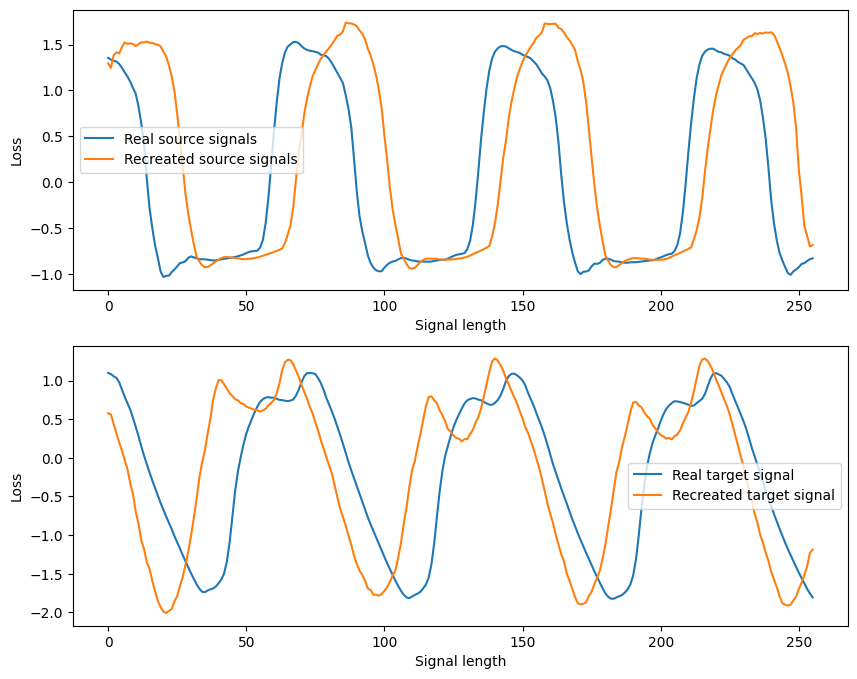

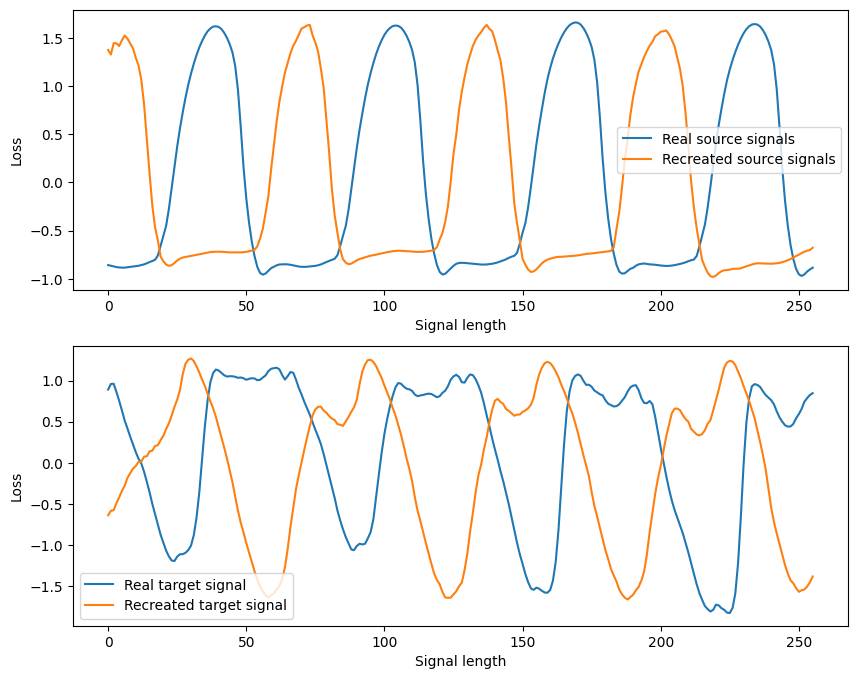

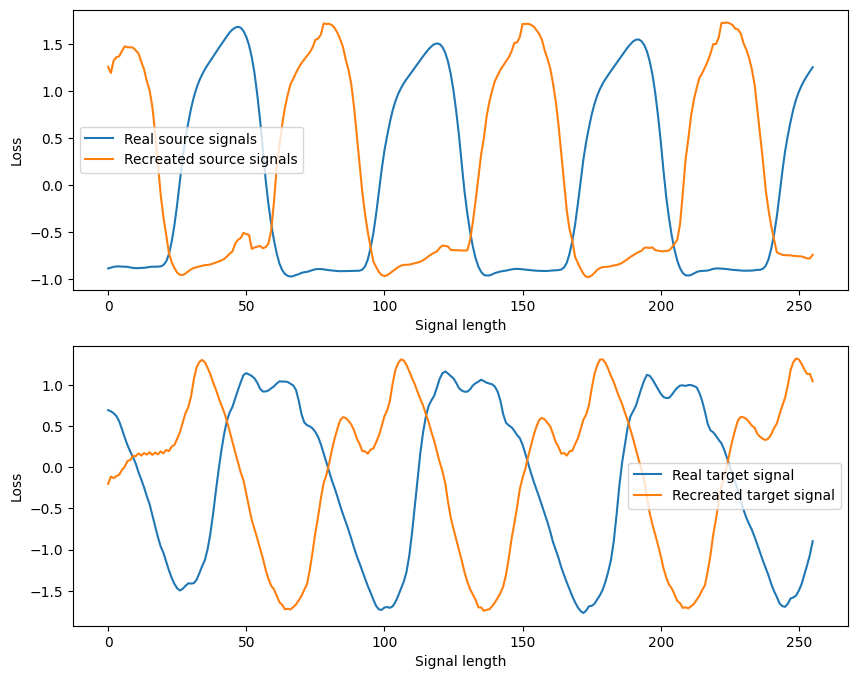

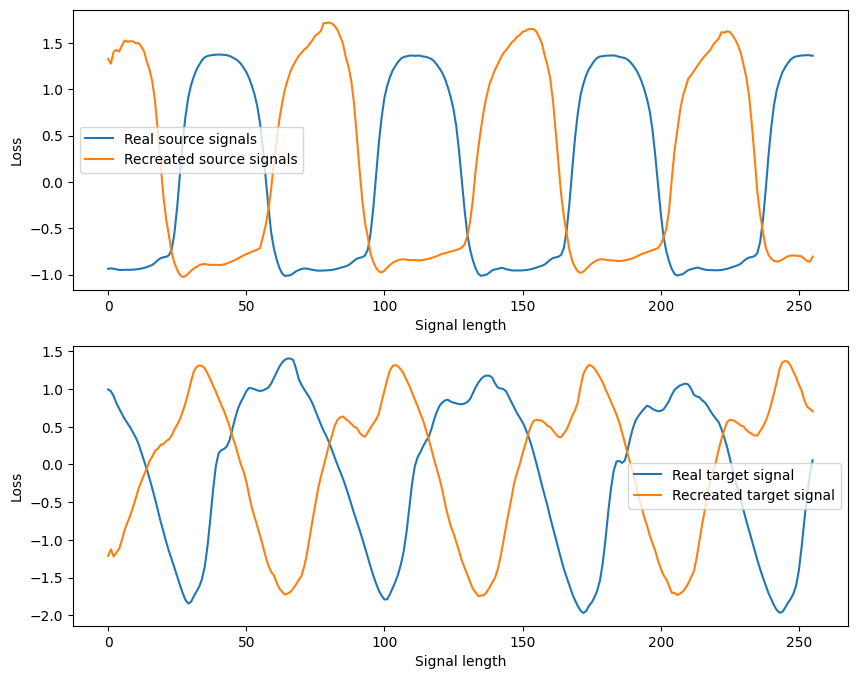

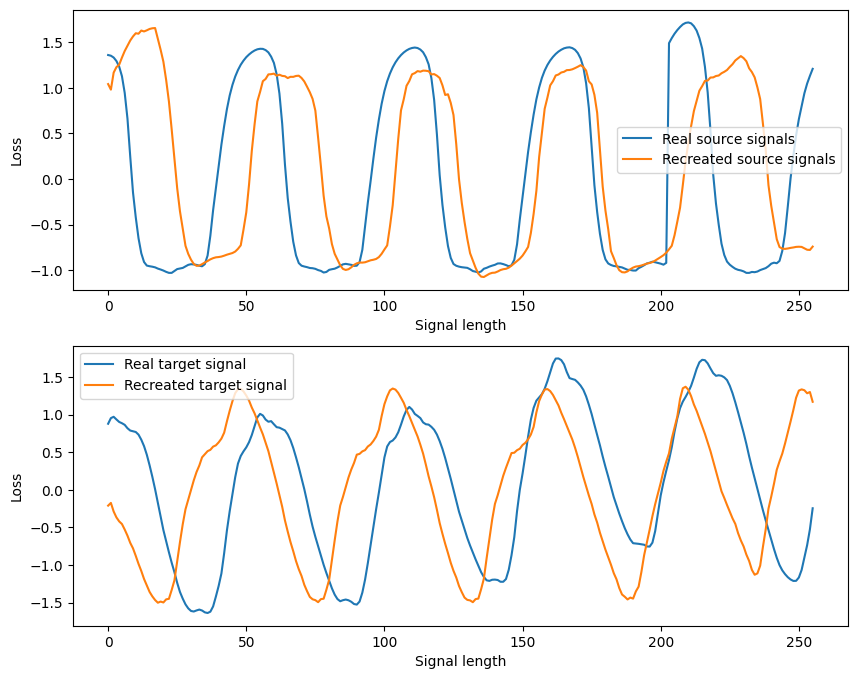

In [30]:
#  Generate signals
idx = 0             

for source, target, in test_loader:
    if idx == 5:
        break                 
                    
    source = source.float()
    target = target.float()
    source = source.to(DEVICE)
    target = target.to(DEVICE)

    fake_target = gen_target(source)
    fake_source = gen_source(target)

                        
    fake_target = fake_target.reshape(-1)
    fake_source = fake_source.reshape(-1)
    source = source.reshape(-1)
    target = target.reshape(-1)

    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(source.cpu().detach().numpy(), label= 'Real source signals')
    ax[0].plot(fake_source.cpu().detach().numpy(), label= 'Recreated source signals')
    ax[0].set_xlabel('Signal length')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(target.cpu().detach().numpy(), label= 'Real target signal')
    ax[1].plot(fake_target.cpu().detach().numpy(), label= 'Recreated target signal')
    ax[1].set_xlabel('Signal length')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    idx += 1       